We will continue with the plan delineated in the 12/07 note on going deeper into the simplex CNV analysis. But in this notebook let's focus on the PennCNV analysis, after the joint calling algorithm that we ran in that notebook.

So, we start with a traditional PennCNV QC:

In [4]:
%%bash
module load penncnv

cd /data/sudregp/cnv/penncnv/results
cat CCGO*.log CLIA*.log > all_simplex.log
cat CCGO*.jointcnv CLIA*.jointcnv > all_simplex.jointcnv
filter_cnv.pl all_simplex.jointcnv -qclogfile all_simplex.log \
    -qcpassout all_simplex.qcpass \
    -qcsumout all_simplex.qcsum -out all_simplex

NOTICE: the --qclrrsd argument is set as 0.3 by default
NOTICE: the --qcbafdrift argument is set as 0.01 by default
NOTICE: the --qcwf argument is set as 0.05 by default
NOTICE: Writting 0 file names that pass QC to qcpass file all_simplex.qcpass
NOTICE: Writting 0 records of QC summary to qcsum file all_simplex.qcsum


So, it turns out that the default values used in QC are not output to the log file if using the joint call. Does that mean that joint calls are not as affected by those metrics? Let's go on with the analysis without doing QC, and then we can check if there any any outliers. If yes, then we can do the usual rawcnv call just to get those QC metrics, and apply them to the joint calls.

So, before we try to import these results into pseq, let's do a quick check of the numbers:

In [3]:
%%bash
cd /data/sudregp/cnv/penncnv/results

for triocnv in `ls -1 C*.jointcnv`; do
    rm denovo.txt inherited.txt 2>/dev/null
    grep mother ${triocnv} > mom_snps;
    grep father ${triocnv} > dad_snps;
    cat mom_snps dad_snps > parent_snps;
    for snp in `grep offspring ${triocnv} | cut -d' ' -f 1`; do
        if ! grep -q $snp parent_snps; then
            echo "$snp" >> denovo.txt
        else
            echo "$snp" >> inherited.txt
        fi;
   done
   echo ${triocnv}: `cat denovo.txt 2>/dev/null | wc -l` denovo, `cat inherited.txt 2>/dev/null | wc -l` inherited;
   rm *_snps;
done

CCGO_800979.jointcnv: 1 denovo, 28 inherited
CCGO_800980.jointcnv: 3 denovo, 43 inherited
CLIA_400121.jointcnv: 0 denovo, 110 inherited
CLIA_400122.jointcnv: 3 denovo, 110 inherited
CLIA_400123.jointcnv: 3 denovo, 53 inherited
CLIA_400125.jointcnv: 283 denovo, 71 inherited
CLIA_400126.jointcnv: 382 denovo, 457 inherited
CLIA_400127.jointcnv: 10 denovo, 71 inherited
CLIA_400128.jointcnv: 1 denovo, 84 inherited
CLIA_400129.jointcnv: 1 denovo, 94 inherited
CLIA_400130.jointcnv: 0 denovo, 215 inherited
CLIA_400131.jointcnv: 4 denovo, 161 inherited
CLIA_400132.jointcnv: 77 denovo, 263 inherited
CLIA_400133.jointcnv: 1 denovo, 188 inherited
CLIA_400134.jointcnv: 3 denovo, 148 inherited
CLIA_400135.jointcnv: 8 denovo, 325 inherited
CLIA_400138.jointcnv: 16 denovo, 120 inherited
CLIA_400139.jointcnv: 49 denovo, 269 inherited
CLIA_400140.jointcnv: 2 denovo, 196 inherited
CLIA_400142.jointcnv: 29 denovo, 284 inherited
CLIA_400144.jointcnv: 0 denovo, 143 inherited
CLIA_400148.jointcnv: 5 denovo, 

Well, there are a few trios that would make you wonder about their data quality. Let me create a QC file and see if these are samples that would be excluded (in terminal):

In [ ]:
%%bash
module load penncnv

cd /data/sudregp/cnv/penncnv

pfb_file=InfiniumExome.pfb
gc_file=InfiniumExome.hg19.gcmodel
detect_cnv.pl -test -hmm ~/autodenovo/penncnv_example.hmm -pfb $pfb_file -log results/all_simplex_but1.log InfiniumExome/* -out results/all_simplex_but1.rawcnv;

pfb_file=HumanExome.pfb
gc_file=HumanExome.hg19.gcmodel
detect_cnv.pl -test -hmm ~/autodenovo/penncnv_example.hmm -pfb $pfb_file -log results/fam_10369.log HumanExome/* -out results/fam_10369.rawcnv;

In [5]:
%%bash

module load penncnv

cd /data/sudregp/cnv/penncnv/results
cat all_simplex_but1.log fam_10369.log > all_simplex_rawcnv.log
cat all_simplex_but1.rawcnv fam_10369.rawcnv > all_simplex.rawcnv
filter_cnv.pl all_simplex.rawcnv -qclogfile all_simplex_rawcnv.log \
    -qcpassout all_simplex.qcpass \
    -qcsumout all_simplex.qcsum -out all_simplex

NOTICE: the --qclrrsd argument is set as 0.3 by default
NOTICE: the --qcbafdrift argument is set as 0.01 by default
NOTICE: the --qcwf argument is set as 0.05 by default
NOTICE: Writting 122 file names that pass QC to qcpass file all_simplex.qcpass
NOTICE: Writting 130 records of QC summary to qcsum file all_simplex.qcsum


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

In [17]:
# figure out who is who in each trio
import glob
data_dir = '/data/sudregp/cnv/penncnv/'
ped_file = '/data/sudregp/cnv/simplex.ped'
wes_prefix = ['CLIA', 'CCGO', 'WPS']
trios = []
affected = []
controls = []
samples = []
fid = open(ped_file, 'r')
for line in fid:
    famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
    if fa[:4] in wes_prefix and mo[:4] in wes_prefix and sid[:4] in wes_prefix:
        fam = {}
        fam['child'] = sid
        if aff == '1':
            affected.append(sid)
        else:
            controls.append(sid)
        fam['father'] = fa
        fam['mother'] = mo
        fam['famid'] = famid
        trios.append(fam)
        samples += [sid, fa, mo]
fid.close()
samples = set(samples)

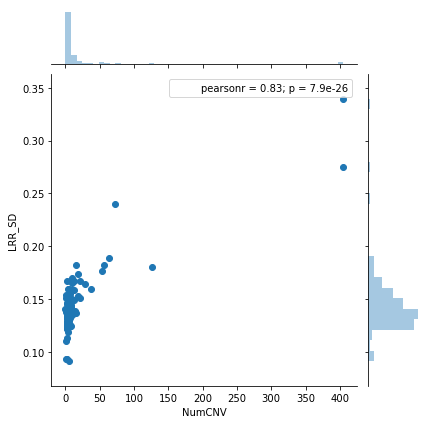

In [21]:
df = pd.read_table('/data/sudregp/cnv/penncnv/results/all_simplex.qcsum')
# we ran for all samples, but let's look at only stats for samples in our simplex study
keep_me = [i for i in range(df.shape[0]) if df.File[i].split('/')[-1] in samples]
df = df.iloc[keep_me]
sns.jointplot(x='NumCNV', y='LRR_SD', data=df)

So, let's look at the cases that seem to be joint calling outliers. Where do they fall in this plot?

In [22]:
df[df.NumCNV > 100]

,File,LRR_mean,LRR_median,LRR_SD,BAF_mean,BAF_median,BAF_SD,BAF_drift,WF,NumCNV
1,InfiniumExome/CLIA_400149,-0.0550,0.0,0.3398,0.5041,0.5,0.0555,0.000391,0.0940,404
8,InfiniumExome/CLIA_400172,0.0251,0.0,0.1802,0.4999,0.5,0.0361,0.000078,0.0495,126
121,InfiniumExome/CLIA_400203,-0.0510,0.0,0.2749,0.5001,0.5,0.0531,0.000348,-0.0916,405


Yep... 400203 is our biggest offender. The other two are also kids and also quite high... OK, so let's use these raw CNV calls to clean up the joint CNV data as well:

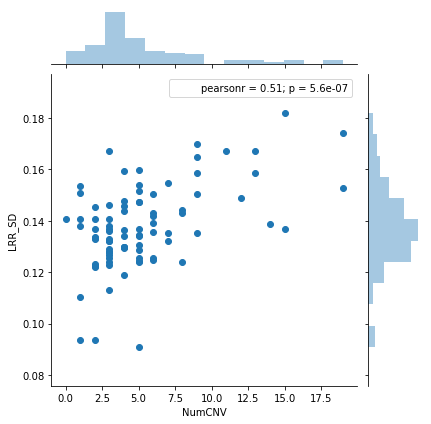

In [27]:
sns.jointplot(x='NumCNV', y='LRR_SD', data=df[df.NumCNV <= 20])

This seems like a potential cutoff. But we can also play with 10. 

In [28]:
df20 = df[df.NumCNV <= 20]
df10 = df[df.NumCNV <= 10]

Now, let's check that the remaining subjects have decent numbers:

In [34]:
fid = open('/data/sudregp/cnv/penncnv/good_kids_numCNVse20.txt', 'w')
for f in df20.File:
    sample = f.split('/')[-1]
    # control and affected only include kids!
    if sample in controls + affected:
        fid.write(sample + '\n')
fid.close()

In [35]:
%%bash
cd /data/sudregp/cnv/penncnv/results

while read sample; do
    triocnv=${sample}'.jointcnv'
    rm denovo.txt inherited.txt 2>/dev/null
    grep mother ${triocnv} > mom_snps;
    grep father ${triocnv} > dad_snps;
    cat mom_snps dad_snps > parent_snps;
    for snp in `grep offspring ${triocnv} | cut -d' ' -f 1`; do
        if ! grep -q $snp parent_snps; then
            echo "$snp" >> denovo.txt
        else
            echo "$snp" >> inherited.txt
        fi;
   done
   echo ${triocnv}: `cat denovo.txt 2>/dev/null | wc -l` denovo, `cat inherited.txt 2>/dev/null | wc -l` inherited;
   rm *_snps;
done < ../good_kids_numCNVse20.txt

CLIA_400140.jointcnv: 2 denovo, 196 inherited
CLIA_400138.jointcnv: 16 denovo, 120 inherited
CLIA_400121.jointcnv: 0 denovo, 110 inherited
CLIA_400191.jointcnv: 0 denovo, 160 inherited
CLIA_400148.jointcnv: 5 denovo, 117 inherited
CLIA_400153.jointcnv: 7 denovo, 89 inherited
CLIA_400216.jointcnv: 6 denovo, 79 inherited
CLIA_400189.jointcnv: 0 denovo, 155 inherited
CLIA_400180.jointcnv: 0 denovo, 105 inherited
CLIA_400166.jointcnv: 11 denovo, 193 inherited
CLIA_400122.jointcnv: 3 denovo, 110 inherited
CLIA_400204.jointcnv: 0 denovo, 190 inherited
CCGO_800979.jointcnv: 1 denovo, 28 inherited
CLIA_400162.jointcnv: 95 denovo, 226 inherited
CLIA_400158.jointcnv: 45 denovo, 116 inherited
CLIA_400170.jointcnv: 0 denovo, 172 inherited
CLIA_400123.jointcnv: 3 denovo, 53 inherited
CLIA_400209.jointcnv: 3 denovo, 280 inherited
CLIA_400134.jointcnv: 3 denovo, 148 inherited
CLIA_400131.jointcnv: 4 denovo, 161 inherited
CLIA_400195.jointcnv: 4 denovo, 344 inherited
CLIA_400135.jointcnv: 8 denovo, 32

This is a bit better, and it might go down even further if we restrict the CNVs by size, or play a bit with the tool parameters. It might also change if we restrict it to genes only, or brain only regions. So, let's check how to import these results into pseq.

In [84]:
import re


regex = re.compile('^chr(\d+):(\d+)-(\d+)\s+numsnp=(\d+)\s+\S+\s+\S+cn=(\d+)\s+\S+/(\S+)')
fout = open('/data/sudregp/cnv/penncnv/joint_call_numCNVse20.cnv', 'w')

for f in df20.File:
    good_sample = f.split('/')[-1]
    if good_sample in controls + affected:
        famid = [t['famid'] for t in trios if t['child'] == good_sample][0]
        fname = '/data/sudregp/cnv/penncnv/results/%s.jointcnv' % good_sample
        fid = open(fname, 'r')
        for line in fid:
            match = regex.search(line)
            chr, start, end, numsnp, cn, sample = match.groups()
            fout.write('\t'.join([famid, sample, chr, start, end, cn, numsnp,
                                  '0']) + '\n')
fout.close()

Now we import it into PLINK:

In [94]:
%%bash

module load plink/1.07

cd /data/sudregp/cnv/penncnv/
cp /data/NCR_SBRB/simplex/simplex.ped joint_call_numCNVse20.fam
plink --cfile joint_call_numCNVse20 --cnv-make-map --out joint_call_numCNVse20 --noweb --1
plink --cfile joint_call_numCNVse20 --noweb --cnv-check-no-overlap  --1


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ joint_call_numCNVse20.log ]
Analysis started: Fri Dec  8 14:17:04 2017

Options in effect:
	--cfile joint_call_numCNVse20
	--cnv-make-map
	--out joint_call_numCNVse20
	--noweb
	--1


Reading segment list (CNVs) from [ joint_call_numCNVse20.cnv ]
Writing new MAP file to [ joint_call_numCNVse20.cnv.map ]
Wrote 9189 unique positions to file

Analysis finished: Fri Dec  8 14:17:04 2017


@-------------------------------------------------------

And we intersect with the regions that code for genes. Because of the arrays we're using, these should be many. But in any case...

In [96]:
%%bash
module load plink/1.07

cd /data/sudregp/cnv/penncnv/
cp /data/NCR_SBRB/simplex/xhmm/gene_locations.txt .

plink --cfile joint_call_numCNVse20 --noweb --1 --cnv-disrupt \
    --cnv-intersect gene_locations.txt --cnv-write \
    --out joint_call_numCNVse20_gene_disrupt


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ joint_call_numCNVse20_gene_disrupt.log ]
Analysis started: Fri Dec  8 14:21:32 2017

Options in effect:
	--cfile joint_call_numCNVse20
	--noweb
	--1
	--cnv-disrupt
	--cnv-intersect gene_locations.txt
	--cnv-write
	--out joint_call_numCNVse20_gene_disrupt

Reading marker information from [ joint_call_numCNVse20.cnv.map ]
9189 (of 9189) markers to be included from [ joint_call_numCNVse20.cnv.map ]
Reading individual information from [ joint_

OK, the percentage of removed regions makes sense. Now, let's run pseq and make a few plots.

In [105]:
%%bash

module load plink/1.07

cd /data/sudregp/cnv/penncnv/
plink --cfile joint_call_numCNVse20_gene_disrupt --cnv-make-map --noweb --1 \
    --out joint_call_numCNVse20_gene_disrupt
    
/data/NCR_SBRB/software/plink_1.9_dev_12082017/plink --cfile joint_call_numCNVse20_gene_disrupt --1 --recode vcf \
    --out joint_call_numCNVse20_gene_disrupt.vcf


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ joint_call_numCNVse20_gene_disrupt.log ]
Analysis started: Fri Dec  8 15:28:10 2017

Options in effect:
	--cfile joint_call_numCNVse20_gene_disrupt
	--cnv-make-map
	--noweb
	--1
	--out joint_call_numCNVse20_gene_disrupt


Reading segment list (CNVs) from [ joint_call_numCNVse20_gene_disrupt.cnv ]
Writing new MAP file to [ joint_call_numCNVse20_gene_disrupt.cnv.map ]
Wrote 8931 unique positions to file

Analysis finished: Fri Dec  8 15:28:1

So, unfortunately here I reached a dead-end, as the old PLINK doesn't export VCFs, and the new one doesn't have exporting CNVs implemented yet. So, I cannot export my calls from it. I also could not find a way to convert the calls directly from PennCNV to VCF, which would also work. That's the route I took with XHMM. So, we'll need to use the PennCNV to do the CNV calling, and then import them separately into PLINK to assess different markers (e.g. gene disruption, brain expression, denovo, etc). 

The file I created to import into PLINK should have all the joint call variants for all samples: joint_call_numCNVse20.cnv. So, I could just use that if all I'm looking for is total CNV burden. If I'm looking for denovo variants, I could do it manually (as before), or use PennCNV's tool. The nice thing about PennCNV's tool is that it assigns p-values to all de-novo CNVs. For example:

In [126]:
%%bash

cd /data/sudregp/cnv/penncnv/results

triocnv='CLIA_400127.jointcnv'
rm denovo.txt inherited.txt 2>/dev/null
grep mother ${triocnv} > mom_snps;
grep father ${triocnv} > dad_snps;
cat mom_snps dad_snps > parent_snps;
grep offspring ${triocnv} > kid_snps;
while read line; do
    IFS=' ' read -ra arr <<< "$line"
    snp=${arr[0]}
    if ! grep -q $snp parent_snps; then
        echo $line >> denovo.txt
    else
        echo $line >> inherited.txt
    fi;
done < kid_snps;
echo ${triocnv}: `cat denovo.txt 2>/dev/null | wc -l` denovo, `cat inherited.txt 2>/dev/null | wc -l` inherited;
rm *_snps;
head denovo.txt

CLIA_400127.jointcnv: 10 denovo, 71 inherited
chr6:170102887-170102970 numsnp=3 length=84 state2,cn=1 InfiniumExome/CLIA_400127 startsnp=exm596102 endsnp=exm596109 offspring statepath=332
chr8:144990587-144992782 numsnp=33 length=2,196 state2,cn=1 InfiniumExome/CLIA_400127 startsnp=exm728992 endsnp=exm729175 offspring statepath=532
chr9:140167307-140196334 numsnp=6 length=29,028 state2,cn=1 InfiniumExome/CLIA_400127 startsnp=exm803033 endsnp=exm803109 offspring statepath=332-532
chr13:53420234-53422337 numsnp=7 length=2,104 state2,cn=1 InfiniumExome/CLIA_400127 startsnp=exm1070833 endsnp=exm1070902 offspring statepath=332
chr16:68056661-68057101 numsnp=9 length=441 state2,cn=1 InfiniumExome/CLIA_400127 startsnp=exm1865122 endsnp=exm1251113 offspring statepath=532
chr19:5455990-5456142 numsnp=6 length=153 state2,cn=1 InfiniumExome/CLIA_400127 startsnp=exm1411591 endsnp=exm1411604 offspring statepath=332
chr19:44223113-44223833 numsnp=9 length=721 state2,cn=1 InfiniumExome/CLIA_400127 st

In [127]:
[t for t in trios if t['child'] == 'CLIA_400127']

[{'child': 'CLIA_400127',
  'famid': '10033',
  'father': 'CLIA_400197',
  'mother': 'CLIA_400167'}]

In [131]:
%%bash

module load penncnv

cd /data/sudregp/cnv/penncnv
box='InfiniumExome'
infer_snp_allele.pl -pfb ${box}.pfb -hmm penncnv_example.hmm -denovocn 1 \
    ${box}/CLIA_400197 ${box}/CLIA_400167 ${box}/CLIA_400127 -out tempfile \
    --startsnp exm596102 --endsnp exm596109

NOTICE: Reading marker coordinates and population frequency of B allele (PFB) from InfiniumExome.pfb ... Done with 242917 records (428 records in chr XY,MT,0 were discarded)
NOTICE: For the region chr6:170102887-170102970, 3 markers were identified from InfiniumExome/CLIA_400197
NOTICE: For the region chr6:170102887-170102970, 3 markers were identified from InfiniumExome/CLIA_400167
NOTICE: For the region chr6:170102887-170102970, 3 markers were identified from InfiniumExome/CLIA_400127
NOTICE: Analyzing trio InfiniumExome/CLIA_400197 InfiniumExome/CLIA_400167 InfiniumExome/CLIA_400127
NOTICE: No evidence of parental origin for the putative de novo CNVs (de novo CN=1 in trio InfiniumExome/CLIA_400197 InfiniumExome/CLIA_400167 InfiniumExome/CLIA_400127 )


Or let's look at a bigger region:

In [132]:
%%bash

module load penncnv

cd /data/sudregp/cnv/penncnv
box='InfiniumExome'
infer_snp_allele.pl -pfb ${box}.pfb -hmm penncnv_example.hmm -denovocn 1 \
    ${box}/CLIA_400197 ${box}/CLIA_400167 ${box}/CLIA_400127 -out tempfile \
    --startsnp exm728992 --endsnp exm729175

NOTICE: Reading marker coordinates and population frequency of B allele (PFB) from InfiniumExome.pfb ... Done with 242917 records (428 records in chr XY,0,MT were discarded)
NOTICE: For the region chr8:144990587-144992782, 33 markers were identified from InfiniumExome/CLIA_400197
NOTICE: For the region chr8:144990587-144992782, 33 markers were identified from InfiniumExome/CLIA_400167
NOTICE: For the region chr8:144990587-144992782, 33 markers were identified from InfiniumExome/CLIA_400127
NOTICE: Analyzing trio InfiniumExome/CLIA_400197 InfiniumExome/CLIA_400167 InfiniumExome/CLIA_400127
NOTICE: No evidence of parental origin for the putative de novo CNVs (de novo CN=1 in trio InfiniumExome/CLIA_400197 InfiniumExome/CLIA_400167 InfiniumExome/CLIA_400127 )


Still, very low p-value... good I guess. Let's try the other command, for inherited CNVs:

In [134]:
%%bash

cd /data/sudregp/cnv/penncnv/results
head inherited.txt

chr1:877556-878744 numsnp=5 length=1,189 state2,cn=1 InfiniumExome/CLIA_400127 startsnp=exm116 endsnp=exm158 offspring statepath=322
chr1:1431109-1431163 numsnp=3 length=55 state2,cn=1 InfiniumExome/CLIA_400127 startsnp=exm3724 endsnp=exm3727 offspring statepath=322
chr1:11008295-11008532 numsnp=5 length=238 state2,cn=1 InfiniumExome/CLIA_400127 startsnp=exm13773 endsnp=exm13789 offspring statepath=232
chr1:108185282-108298086 numsnp=7 length=112,805 state2,cn=1 InfiniumExome/CLIA_400127 startsnp=exm79173 endsnp=exm79215 offspring statepath=232
chr1:114682286-114682445 numsnp=5 length=160 state2,cn=1 InfiniumExome/CLIA_400127 startsnp=exm85950 endsnp=exm85959 offspring statepath=232
chr1:205492387-205492679 numsnp=5 length=293 state2,cn=1 InfiniumExome/CLIA_400127 startsnp=exm142359 endsnp=exm142369 offspring statepath=322
chr1:236347143-236347189 numsnp=3 length=47 state2,cn=1 InfiniumExome/CLIA_400127 startsnp=exm161587 endsnp=exm161591 offspring statepath=232
chr2:74438406-74450058 

In [137]:
%%bash

module load penncnv

cd /data/sudregp/cnv/penncnv
box='InfiniumExome'
infer_snp_allele.pl -pfb ${box}.pfb -hmm penncnv_example.hmm -denovocn 3 \
    ${box}/CLIA_400197 ${box}/CLIA_400167 ${box}/CLIA_400127 -out tempfile \
    --startsnp exm924016 --endsnp exm924087

NOTICE: Reading marker coordinates and population frequency of B allele (PFB) from InfiniumExome.pfb ... Done with 242917 records (428 records in chr 0,XY,MT were discarded)
NOTICE: For the region chr11:64600723-64603925, 14 markers were identified from InfiniumExome/CLIA_400197
NOTICE: For the region chr11:64600723-64603925, 14 markers were identified from InfiniumExome/CLIA_400167
NOTICE: For the region chr11:64600723-64603925, 14 markers were identified from InfiniumExome/CLIA_400127
NOTICE: Analyzing trio InfiniumExome/CLIA_400197 InfiniumExome/CLIA_400167 InfiniumExome/CLIA_400127
NOTICE: No evidence of parental origin for the putative de novo CNVs (de novo CN=3 in trio InfiniumExome/CLIA_400197 InfiniumExome/CLIA_400167 InfiniumExome/CLIA_400127 )


Not sure what's going on here... these should be inherited, so why is there no evidence of parental origin for this CNV? That's actually true  when I look at tempfile... is the joint calling screwing something up? Let's see if we can find evidence for any of the 81 CNVs found in the offspring:

In [140]:
%%bash

module load penncnv

cd /data/sudregp/cnv/penncnv
box='InfiniumExome'
triocnv='results/CLIA_400127.jointcnv'
grep offspring ${triocnv} > kid_snps;
while read line; do
    IFS=' ' read -ra cnv <<< "$line"
    IFS='=' read -ra arr <<< "${cnv[3]}"
    ncnv=${arr[1]}
    IFS='=' read -ra arr <<< "${cnv[5]}"
    pstart=${arr[1]}
    IFS='=' read -ra arr <<< "${cnv[6]}"
    pend=${arr[1]}
    
    infer_snp_allele.pl -pfb ${box}.pfb -hmm penncnv_example.hmm -denovocn $ncnv \
    ${box}/CLIA_400197 ${box}/CLIA_400167 ${box}/CLIA_400127 -out tempfile \
    --startsnp $pstart --endsnp $pend
done < kid_snps;
rm *_snps;

NOTICE: Reading marker coordinates and population frequency of B allele (PFB) from InfiniumExome.pfb ... Done with 242917 records (428 records in chr MT,0,XY were discarded)
NOTICE: For the region chr1:877556-878744, 5 markers were identified from InfiniumExome/CLIA_400197
NOTICE: For the region chr1:877556-878744, 5 markers were identified from InfiniumExome/CLIA_400167
NOTICE: For the region chr1:877556-878744, 5 markers were identified from InfiniumExome/CLIA_400127
NOTICE: Analyzing trio InfiniumExome/CLIA_400197 InfiniumExome/CLIA_400167 InfiniumExome/CLIA_400127
NOTICE: No evidence of parental origin for the putative de novo CNVs (de novo CN=1 in trio InfiniumExome/CLIA_400197 InfiniumExome/CLIA_400167 InfiniumExome/CLIA_400127 )
NOTICE: Reading marker coordinates and population frequency of B allele (PFB) from InfiniumExome.pfb ... Done with 242917 records (428 records in chr XY,MT,0 were discarded)
NOTICE: For the region chr1:1431109-1431163, 3 markers were identified from Infi

But I think that's because parents are assumed to be CN=2 when using denovo calls. Let's check what happens when we do that, and then don't:

In [143]:
%%bash

module load penncnv

cd /data/sudregp/cnv/penncnv

grep chr11:64600723-64603925 results/CLIA_400127.jointcnv

box='InfiniumExome'

infer_snp_allele.pl -pfb ${box}.pfb -hmm penncnv_example.hmm -denovocn 3 \
    ${box}/CLIA_400197 ${box}/CLIA_400167 ${box}/CLIA_400127 -out tempfile \
    --startsnp exm924016 --endsnp exm924087
    
head tempfile

infer_snp_allele.pl -pfb ${box}.pfb -hmm penncnv_example.hmm -allcn 233 \
    ${box}/CLIA_400197 ${box}/CLIA_400167 ${box}/CLIA_400127 -out tempfile \
    --startsnp exm924016 --endsnp exm924087
    
head tempfile

chr11:64600723-64603925       numsnp=14     length=3,203       state5,cn=3 InfiniumExome/CLIA_400167 startsnp=exm924016 endsnp=exm924087 mother statepath=555
chr11:64600723-64603925       numsnp=14     length=3,203       state5,cn=3 InfiniumExome/CLIA_400127 startsnp=exm924016 endsnp=exm924087 offspring statepath=555
Name	LRR_F	LRR_M	LRR_O	BAF_F	BAF_M	BAF_O	GENO_F	GENO_M	GENO_O	Origin
exm924016	0.1814	0.2236	0.1997	1.0000	1.0000	0.9557	BB	BB	BBB	?
exm1728116	0.4458	0.3950	0.3197	1.0000	1.0000	0.9945	BB	BB	BBB	?
exm924027	0.4728	0.4719	0.1905	1.0000	1.0000	0.9887	BB	BB	BBB	?
exm924031	0.1405	0.1147	-0.0097	1.0000	1.0000	1.0000	BB	BB	BBB	?
exm924033	0.3733	0.0748	0.1137	1.0000	0.9973	1.0000	BB	BB	BBB	?
exm924036	0.4765	0.0757	0.2052	1.0000	1.0000	1.0000	BB	BB	BBB	?
exm924047	0.5972	0.4006	0.3598	1.0000	1.0000	1.0000	BB	BB	BBB	?
exm924054	0.3457	0.1414	0.4115	1.0000	0.9966	0.9984	BB	BB	BBB	?
exm924061	0.2227	0.1777	0.1742	1.0000	1.0000	0.9989	BB	BB	BBB	?
Name	LRR(1)	LRR(2)	LRR(3)	BAF(1)	B

NOTICE: Reading marker coordinates and population frequency of B allele (PFB) from InfiniumExome.pfb ... Done with 242917 records (428 records in chr MT,XY,0 were discarded)
NOTICE: For the region chr11:64600723-64603925, 14 markers were identified from InfiniumExome/CLIA_400197
NOTICE: For the region chr11:64600723-64603925, 14 markers were identified from InfiniumExome/CLIA_400167
NOTICE: For the region chr11:64600723-64603925, 14 markers were identified from InfiniumExome/CLIA_400127
NOTICE: Analyzing trio InfiniumExome/CLIA_400197 InfiniumExome/CLIA_400167 InfiniumExome/CLIA_400127
NOTICE: No evidence of parental origin for the putative de novo CNVs (de novo CN=3 in trio InfiniumExome/CLIA_400197 InfiniumExome/CLIA_400167 InfiniumExome/CLIA_400127 )
NOTICE: Reading marker coordinates and population frequency of B allele (PFB) from InfiniumExome.pfb ... Done with 242917 records (428 records in chr XY,0,MT were discarded)
NOTICE: For the region chr11:64600723-64603925, 14 markers wer

OK, so this is a bit better. Basically, it only makes sense to calculate p-values for denovo calls, because of the assumption that both parents are cn=2. And the genotyping changes based on that cn. Now, the question is whether we need to calculate these p-values or not. Let's not do it for now, and just generate a nice set of variants for plink, splitting it into inherited and denovo variants.

In [162]:
%%bash
cd /data/sudregp/cnv/penncnv/results

rm denovo_numCNVse20.txt inherited_numCNVse20.txt 2>/dev/null

while read sample; do
    triocnv=${sample}'.jointcnv'
    grep mother ${triocnv} > mom_snps;
    grep father ${triocnv} > dad_snps;
    cat mom_snps dad_snps > parent_snps;
    grep offspring ${triocnv} > kid_snps;
    while read line; do
        IFS=' ' read -ra arr <<< "$line"
        snp=${arr[0]}
        if ! grep -q $snp parent_snps; then
            echo $line >> denovo_numCNVse20.txt
        else
            echo $line >> inherited_numCNVse20.txt
        fi;
    done < kid_snps;
    rm *_snps;
done < ../good_kids_numCNVse20.txt

In [163]:
import re


regex = re.compile('^chr(\d+):(\d+)-(\d+)\s+numsnp=(\d+)\s+\S+\s+\S+cn=(\d+)\s+\S+/(\S+)')
fout = open('/data/sudregp/cnv/penncnv/denovo_numCNVse20.cnv', 'w')
fid = open('/data/sudregp/cnv/penncnv/results/denovo_numCNVse20.txt', 'r')
for line in fid:
    match = regex.search(line)
    chr, start, end, numsnp, cn, sample = match.groups()
    fout.write('\t'.join([famid, sample, chr, start, end, cn, numsnp,
                          '0']) + '\n')
fout.close()

fout = open('/data/sudregp/cnv/penncnv/inherited_numCNVse20.cnv', 'w')
fid = open('/data/sudregp/cnv/penncnv/results/inherited_numCNVse20.txt', 'r')
for line in fid:
    match = regex.search(line)
    chr, start, end, numsnp, cn, sample = match.groups()
    fout.write('\t'.join([famid, sample, chr, start, end, cn, numsnp,
                          '0']) + '\n')
fout.close()

In [168]:
%%bash

module load plink/1.07

cd /data/sudregp/cnv/penncnv/

for cnv in denovo inherited; do
    rm ${cnv}*fam ${cnv}*log ${cnv}*summary ${cnv}*indiv ${cnv}*map
    cp /data/NCR_SBRB/simplex/simplex.ped ${cnv}_numCNVse20.fam
    plink --cnv-list ${cnv}_numCNVse20.cnv --cnv-make-map --noweb --out ${cnv}_numCNVse20
    plink --cfile ${cnv}_numCNVse20 --noweb --1 --out ${cnv}_numCNVse20 --cnv-kb 0
#     plink --cfile ${cnv}_numCNVse20 --noweb --1 --cnv-disrupt \
#         --cnv-intersect gene_locations.txt --cnv-write \
#         --out ${cnv}_numCNVse20_gene_disrupt
done


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_numCNVse20.log ]
Analysis started: Fri Dec  8 19:01:28 2017

Options in effect:
	--cnv-list denovo_numCNVse20.cnv
	--cnv-make-map
	--noweb
	--out denovo_numCNVse20


Reading segment list (CNVs) from [ denovo_numCNVse20.cnv ]
Writing new MAP file to [ denovo_numCNVse20.cnv.map ]
Wrote 1370 unique positions to file

Analysis finished: Fri Dec  8 19:01:28 2017


@----------------------------------------------------------@
|        PLIN

These numbers imported by PLINK don't look correct. Need to figure out what's going on. Of course, the other option would be to not use PLINK, but then I'll have to figure out how to trim the list of genes and positions manually. The other otpion is trying parseCNV, which looks a bit buggy, but at least it has all the scripts we'd need: QC, denovo calling, region intersection. 

# TODO

* Give ParseCNV a try (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3597648/pdf/gks1346.pdf)
* Understand what we're QCing on!
* Worth calculating p-values? For that one trio it was always 0!
* Try PennCNV steps with adjusted pipeline to see if we get anything different
* Look into sex chromosomes? Something to the idea that adhd is more present in boys...
* Play with the minimum size of the CNV
* Play with the HMM parameters
* Check (and plot) within family differences; the ones with big differences are interesting.
* Include parent burden in the analysis
* Filter based on neural vs nonneural CNVs (i.e. expressed in the brain
* Look at literature-only CNVs (J Chia and A Thapaer for CNVs in ADHD
* Match with file of ranked simplex by Wendy (maybe blindly)?
* Do all of the above with XHMM and array data. Maybe start with array because it'll be simpler?

# Useful links

* http://research.lunenfeld.ca/gwa_studies/files/file/GWAS/Hadley_CNV/Hadley_CNV_practical.pdf
* http://penncnvexomeseq.sourceforge.net: interesting idea of how to combine PennCNV and XHMM, but seems very beta...
* http://parsecnv.sourceforge.net: seems to come from the same group as above... a bit beta as well
* http://penncnv.openbioinformatics.org/en/latest/user-guide/denovo/